<a href="https://colab.research.google.com/github/RealMyeong/Aiffel_Exploration/blob/main/EX_BS2_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 삼전

## step1. 시계열 데이터 준비

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels
import os

import warnings
warnings.filterwarnings(action = 'ignore')

In [41]:
data = pd.read_csv('/content/drive/MyDrive/캐글_필사/data_주식/005930.KS.csv', index_col = 'Date', parse_dates=True)

In [42]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-22,79000.0,79800.0,78900.0,79700.0,78560.226563,12618790
2021-07-23,79700.0,79900.0,79200.0,79300.0,78165.945313,9098910
2021-07-26,79400.0,79500.0,78800.0,78800.0,77673.101563,10040975
2021-07-27,79200.0,79400.0,78500.0,78500.0,77377.390625,11427693
2021-07-28,78300.0,79200.0,78100.0,79200.0,78067.382813,12743417


## step 2. 각종 전처리

  - 결측치 처리
  - 로그 변환

In [43]:
ts1 = data['Close']
ts1

Date
2021-07-22    79700.0
2021-07-23    79300.0
2021-07-26    78800.0
2021-07-27    78500.0
2021-07-28    79200.0
               ...   
2022-07-18    61900.0
2022-07-19    60900.0
2022-07-20    60500.0
2022-07-21    61800.0
2022-07-22    61300.0
Name: Close, Length: 245, dtype: float64

In [44]:
ts1 = ts1.interpolate(method='time')

ts1.isnull().sum()

0

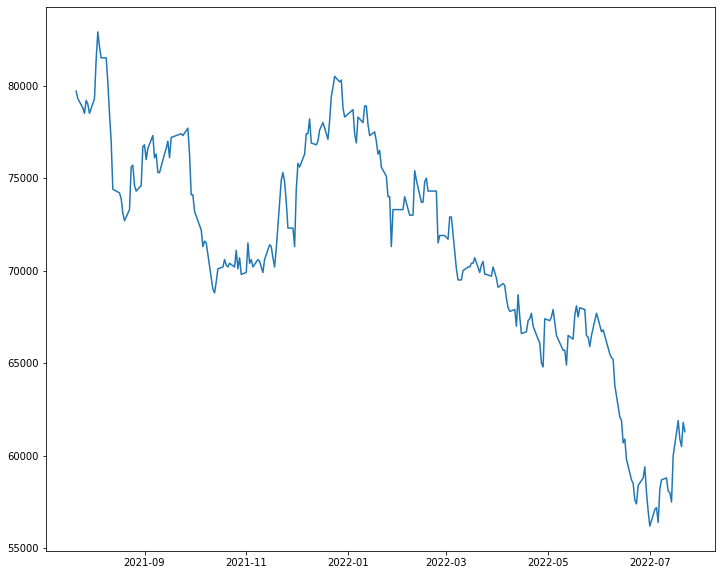

In [45]:
plt.plot(ts1)

In [46]:
# 로그 변환
ts1_log = np.log(ts1)

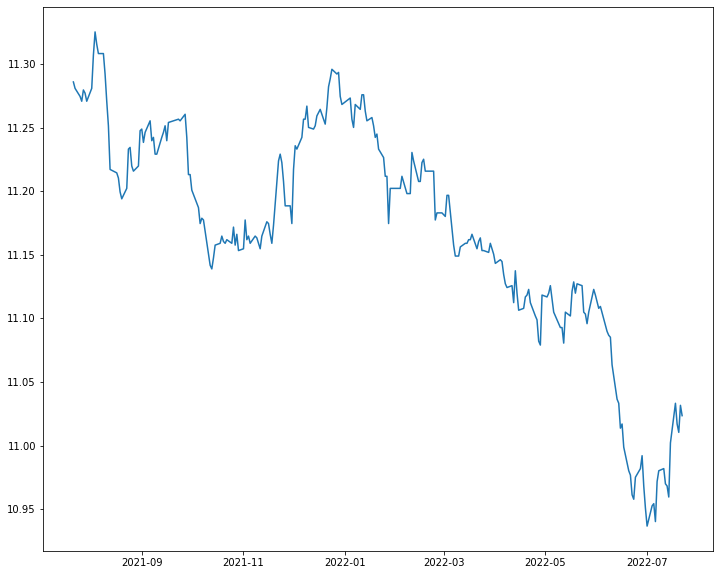

In [47]:
plt.plot(ts1_log)

## step 3. 시계열 안정성 분석

  - 정성적 그래프 분석
  - 정량적 Augumented Dickey-Fuller test
  - 시계열 분해(Time Series Decomposition)
  - Residual 안정성 확인

In [48]:
# 정성적 그래프 분석 함수 정의

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#정량적 Augmented_Dicky_Fuller_Test 함수 정의
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

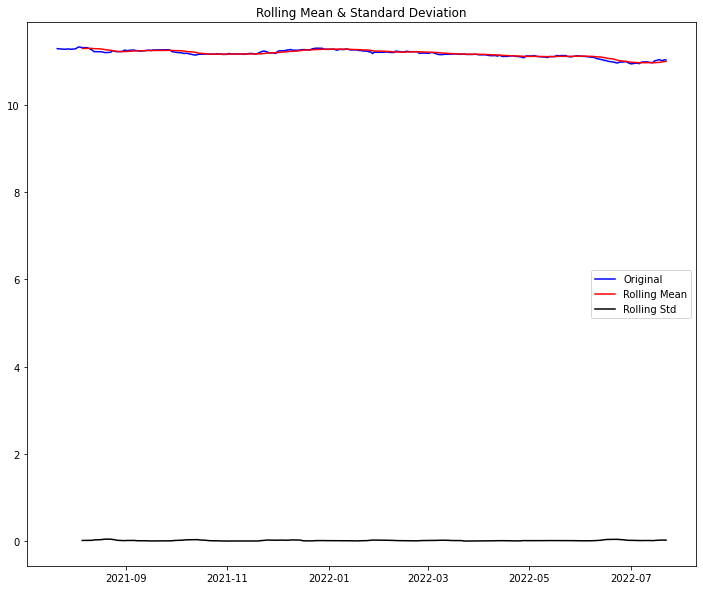

In [49]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log)

In [50]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.015654
p-value                          0.747512
#Lags Used                       0.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


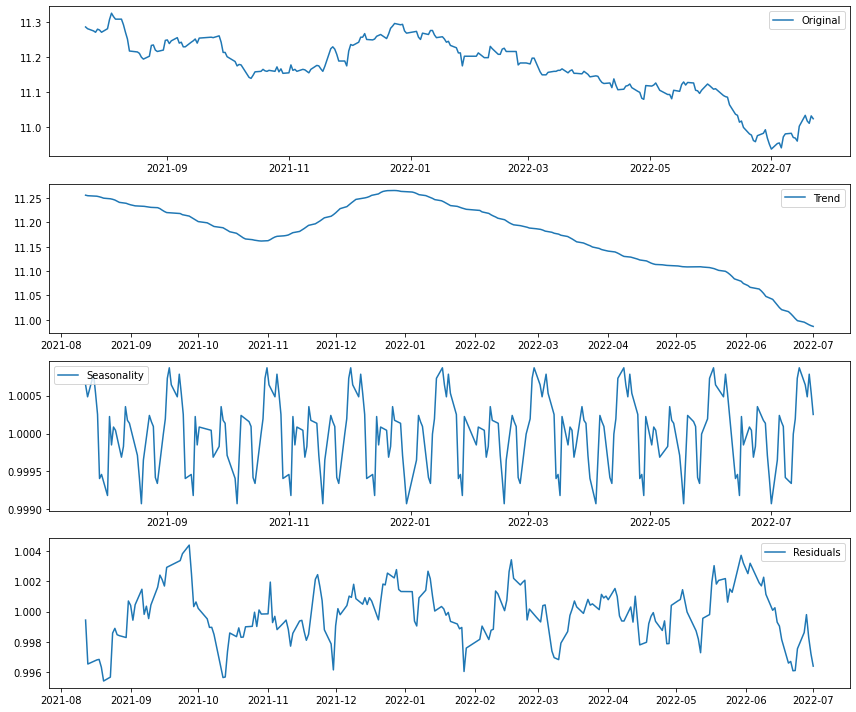

In [51]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

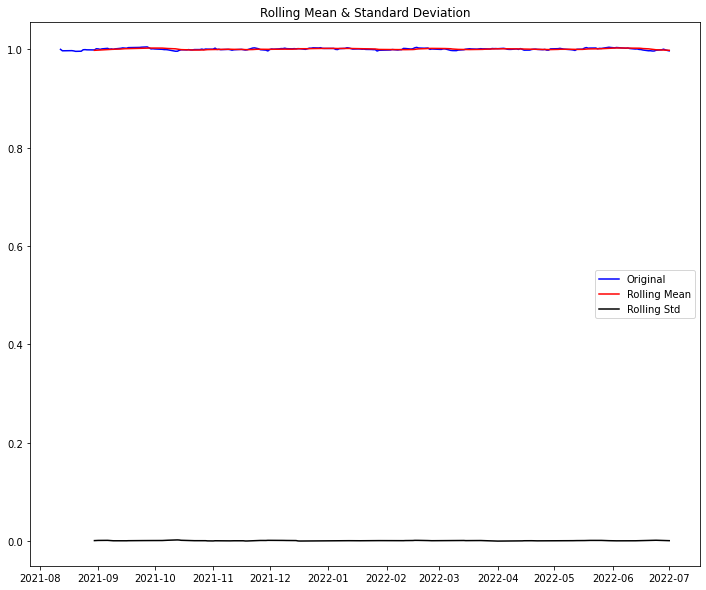

In [52]:
plt.rcParams["figure.figsize"] = (12,10)
plot_rolling_statistics(residual)

residual 에 결측치가 발견되어 dropna()를 이용해 결측치를 제거 후 augmented_dickey_fuller_test진행

In [53]:
residual.isnull().sum()

30

In [54]:
residual = residual.dropna()

In [55]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.854333
p-value                          0.000043
#Lags Used                       1.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


p-value가 거의 0에 가까운 값이 되었으므로 residual은 충분히 안정적인 시계열이라고 할 수 있다.

## step4. 학습, 테스트 데이터 생성

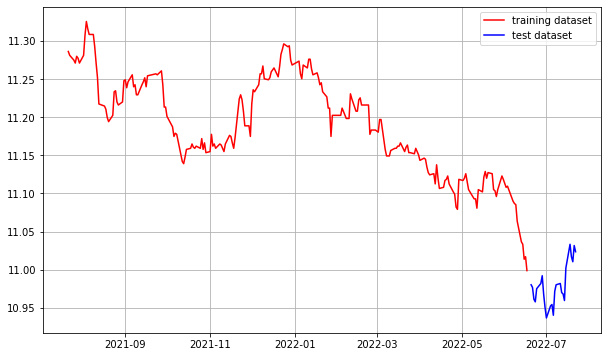

In [56]:
# 데이터가 시계열 데이터 이므로 학습을 시간으로 앞선 데이터로 해준다.
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
train_data.index = pd.DatetimeIndex(train_data.index.values,
                               freq=train_data.index.inferred_freq)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [57]:
test_data.shape, train_data.shape

((25,), (220,))

## step5. ARIMA 모수 찾기

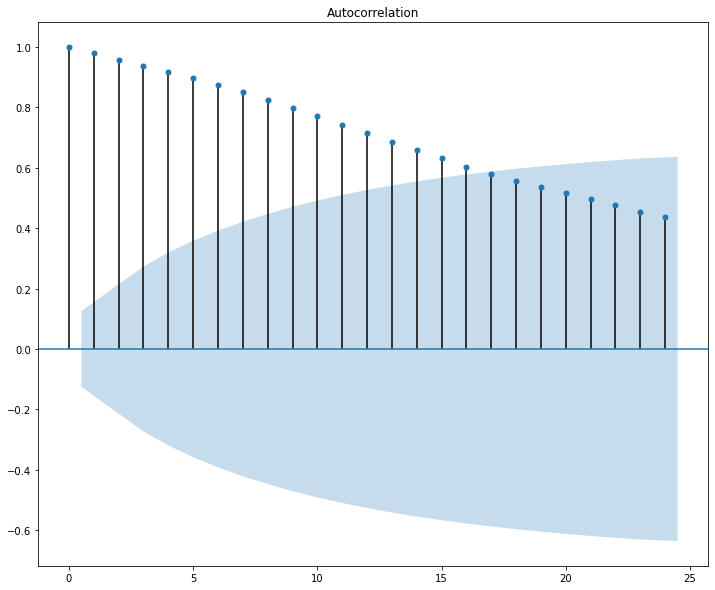

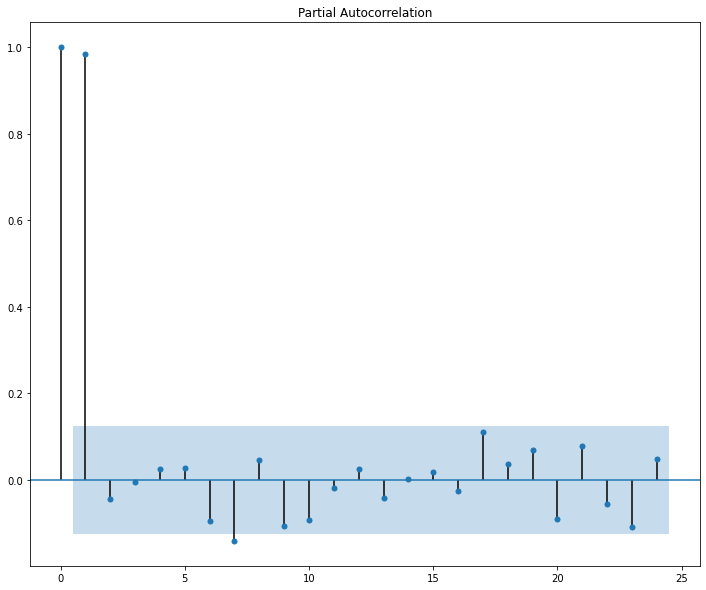

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.435210e+01
p-value                        1.017679e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


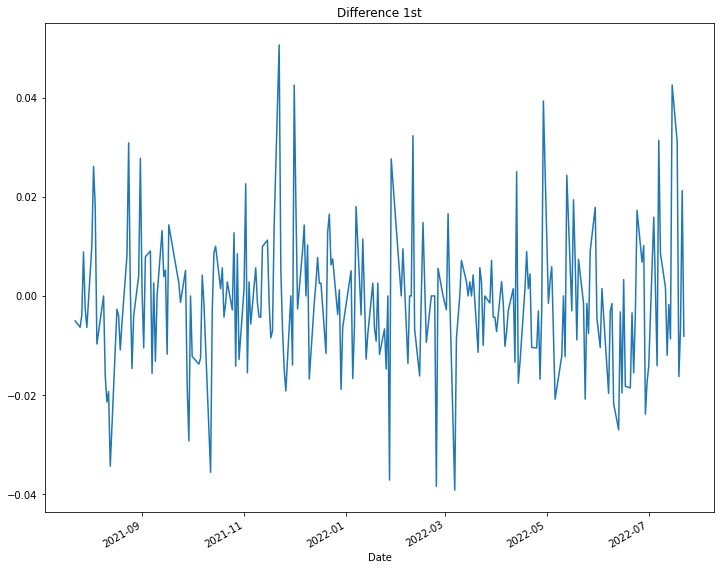

In [59]:
# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

- 위의 ACF, PACF결과 그래프에서 볼 때 ACF가 천천히 0으로 수렴하므로 안정적인 시계열이라고 보기가 힘들다 따라서 arima의 모수 p,q를 구할때는 차분을 한 후 구하는 것이 나을 것 같다.


- 그리고 차분을 했을때 1차 차분으로도 p-value 값이 1.017679e-26 이므로 d=1이 적당한 것 같다.

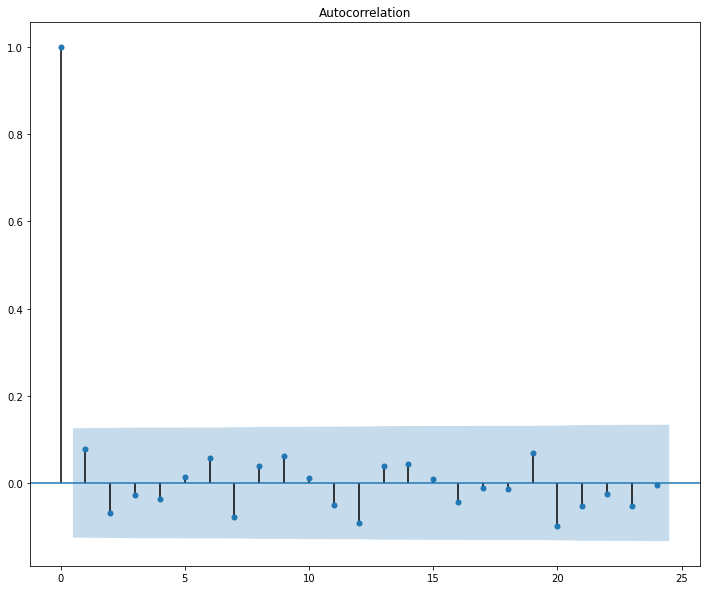

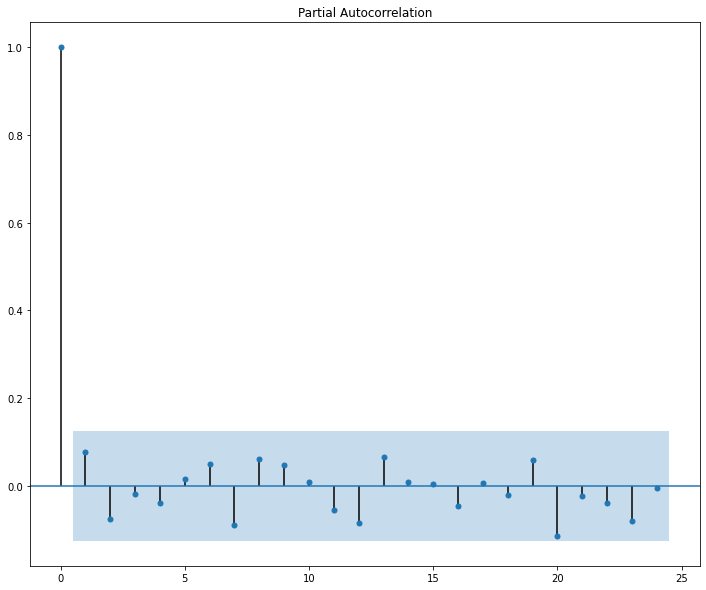

In [60]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- 차분을 진행한 데이터에 대한 ACF, PACF그래프를 보면 모두 1시차 이후로 급격하게 0으로 수렴하는 것을 볼 수 있으므로 p=1, q=1로 설정하는게 좋을 것 같다.

## step6. 모델 훈련, 테스트

In [61]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 1)) # 모수는 이전 그래프를 참고 | 모수를 구할 때 p와 q를 둘 다 구했지만 p,q둘 중 하나는 0이 되어아함
fit_model = model.fit() 

print(fit_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  219
Model:                ARIMA(10, 1, 0)   Log Likelihood                 640.302
Method:                       css-mle   S.D. of innovations              0.013
Date:                Sat, 23 Jul 2022   AIC                          -1256.604
Time:                        12:34:48   BIC                          -1215.935
Sample:                             1   HQIC                         -1240.179
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.001     -1.538      0.126      -0.003       0.000
ar.L1.D.Close      0.0783      0.068      1.156      0.249      -0.054       0.211
ar.L2.D.Close     -0.0373      0.068

In [62]:
model2 = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 | 모수를 구할 때 p와 q를 둘 다 구했지만 p,q둘 중 하나는 0이 되어아함
fit_model2 = model2.fit() 

print(fit_model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  219
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 637.823
Method:                       css-mle   S.D. of innovations              0.013
Date:                Sat, 23 Jul 2022   AIC                          -1269.646
Time:                        12:34:50   BIC                          -1259.479
Sample:                             1   HQIC                         -1265.540
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0013      0.001     -1.385      0.168      -0.003       0.001
ar.L1.D.Close     0.0670      0.068      0.992      0.322      -0.065       0.199
                                    Root

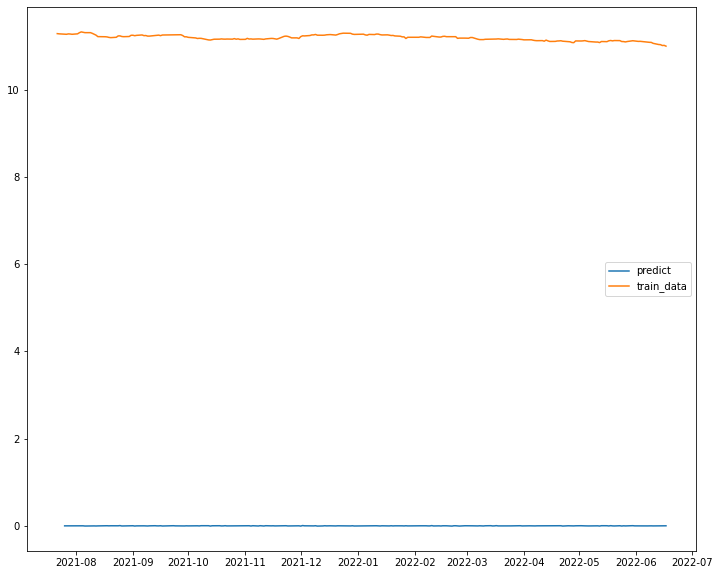

In [63]:
fit_model = fit_model.predict()
fit_model = fit_model.drop(fit_model.index[0])
plt.plot(fit_model, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

- p=10, p=1로 각각 ARIMA모델을 만들었을 때 AIC값이 p=10으로 두었을 때 감소했으므로 p=10으로 두고 예측을 시작

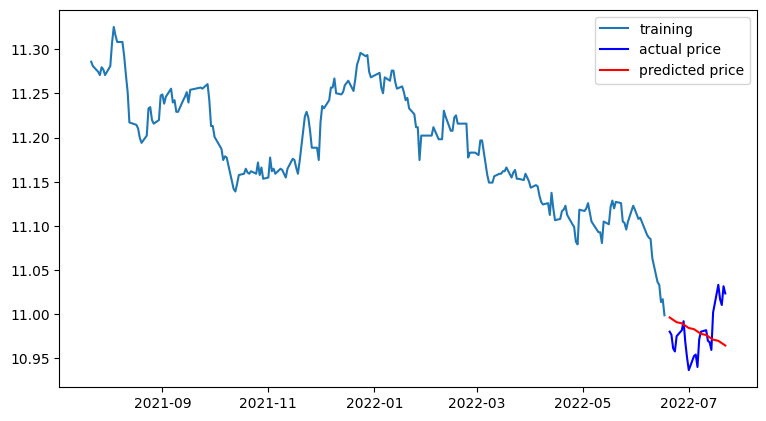

In [64]:
model = ARIMA(train_data, order=(1, 1, 0))  # p값을 1로 학습
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc=np.array(fc[0])
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3845956.334284667
MAE:  1594.6691110041088
RMSE:  1961.1109948915862
MAPE: 2.70%


# 비트코인

## step1. 시계열 데이터 준비

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels
import os

import warnings
warnings.filterwarnings('ignore')

In [67]:
data = pd.read_csv('/content/drive/MyDrive/캐글_필사/data_주식/BTC-USD.csv', index_col = 'Date', parse_dates=True)

In [68]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-22,32138.873047,32576.400391,31745.298828,32313.105469,32313.105469,19555230518
2021-07-23,32305.958984,33581.550781,32057.892578,33581.550781,33581.550781,22552046192
2021-07-24,33593.730469,34490.390625,33424.859375,34292.445313,34292.445313,21664706865
2021-07-25,34290.292969,35364.925781,33881.835938,35350.187500,35350.187500,20856685287
2021-07-26,35384.031250,40499.675781,35287.312500,37337.535156,37337.535156,51022126212


## step2. 각종 전처리

- 결측치 처리
- 로그 변환

In [69]:
ts1 = data['Close']
ts1.head()

Date
2021-07-22    32313.105469
2021-07-23    33581.550781
2021-07-24    34292.445313
2021-07-25    35350.187500
2021-07-26    37337.535156
Name: Close, dtype: float64

In [70]:
ts1.isnull().sum()

0

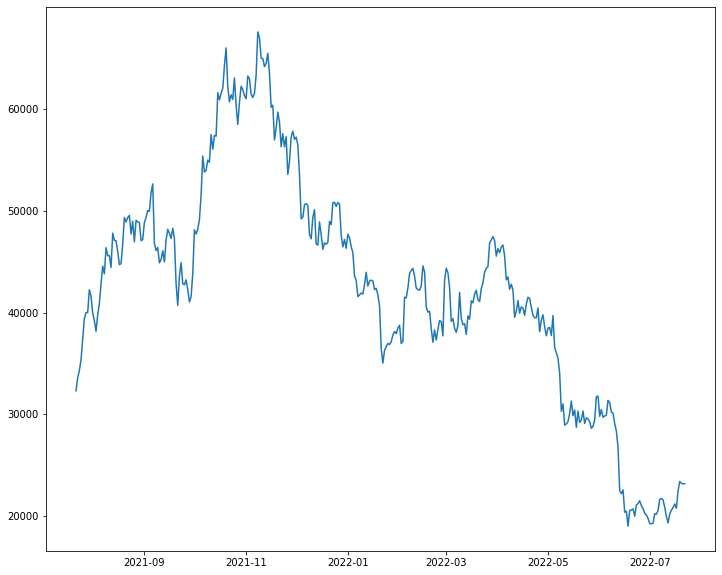

In [71]:
plt.plot(ts1)

In [72]:
ts1_log = np.log(ts1)

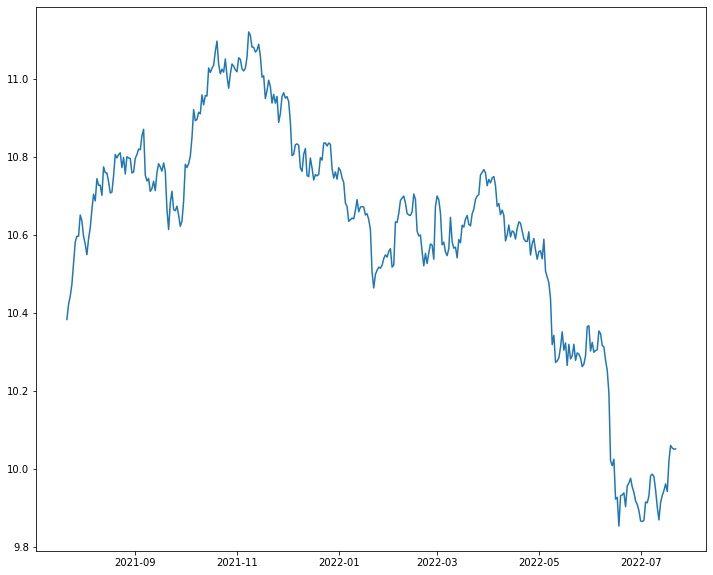

In [73]:
plt.plot(ts1_log)

## step3. 시계열 안정성 분석

  - 정성적 그래프 분석
  - 정량적 Augumented Dickey-Fuller test
  - 시계열 분해(Time Series Decomposition)
  - Residual 안정성 확인

In [74]:
# 정성적 그래프 분석 함수 정의
# 이동평균, 이동표준편차 등을 시각화 해줌

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#정량적 Augmented_Dicky_Fuller_Test 함수 정의
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

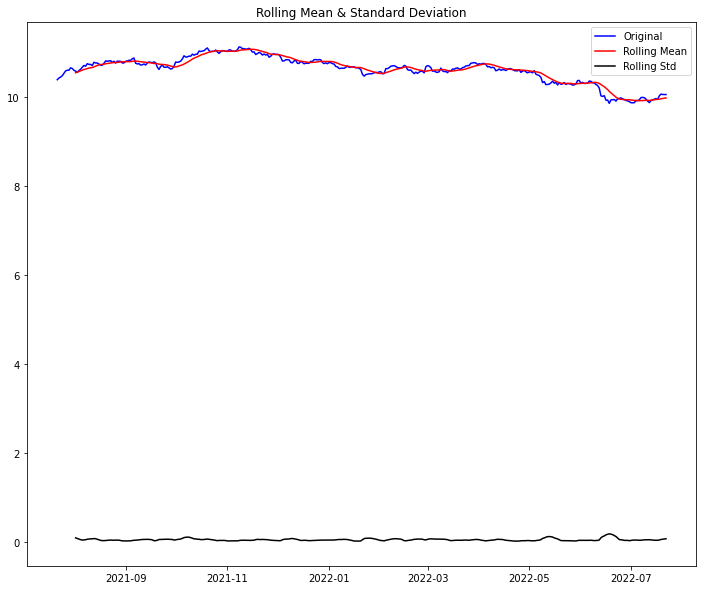

In [75]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log)

In [76]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.505536
p-value                          0.890932
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


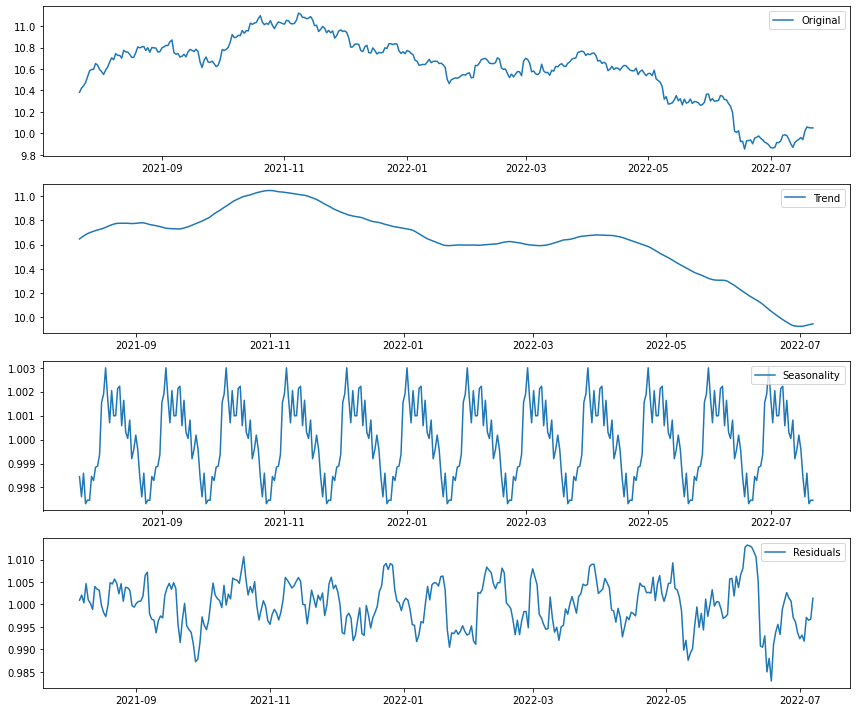

In [77]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Residual에 대한 안정성 측정

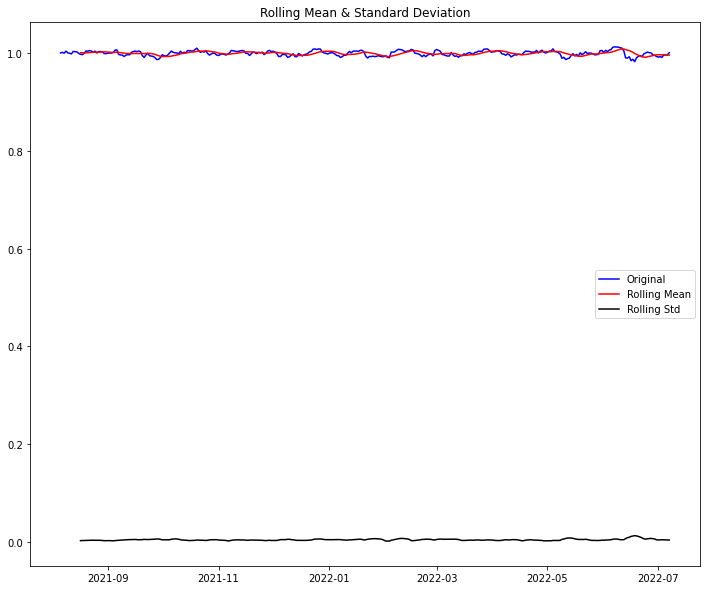

In [78]:
plt.rcParams["figure.figsize"] = (12,10)
plot_rolling_statistics(residual)

In [79]:
residual = residual.dropna()

In [80]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.692154e+00
p-value                        4.083915e-09
#Lags Used                     9.000000e+00
Number of Observations Used    3.260000e+02
Critical Value (1%)           -3.450569e+00
Critical Value (5%)           -2.870447e+00
Critical Value (10%)          -2.571515e+00
dtype: float64


## step4. 적정 ARIMA 모수 찾기

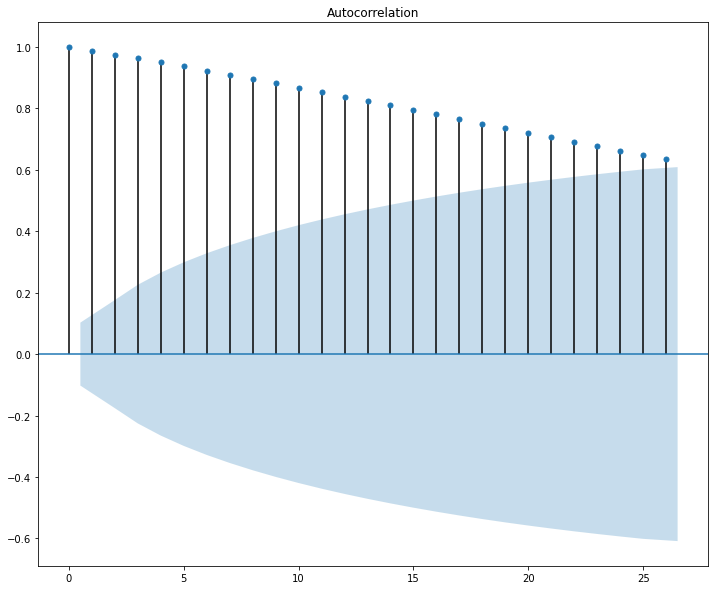

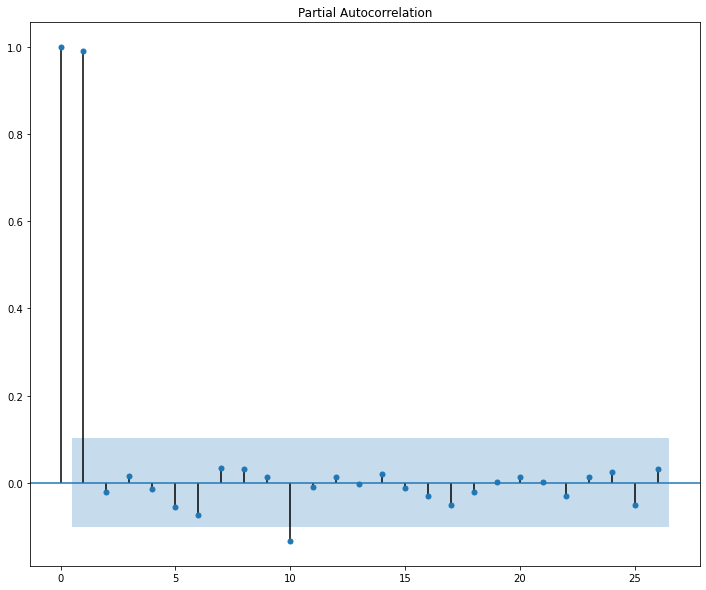

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF그래프로 볼때 이 시계열은 안정적이지 않다.
- 차분하여 안정적이게 된 시계열의 ACF, PACF 그래프에서 p,q를 구하는것이 좋을 것 같다.

- 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.842160e+01
p-value                        2.175841e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.640000e+02
Critical Value (1%)           -3.448443e+00
Critical Value (5%)           -2.869513e+00
Critical Value (10%)          -2.571018e+00
dtype: float64


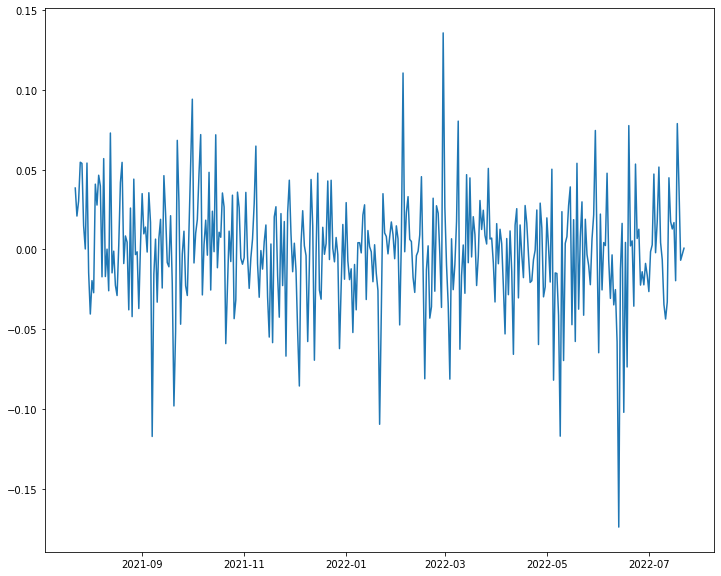

In [82]:
#1차분
diff_1 = ts1_log.diff(periods=1).iloc[1:]
plt.plot(diff_1)
augmented_dickey_fuller_test(diff_1)

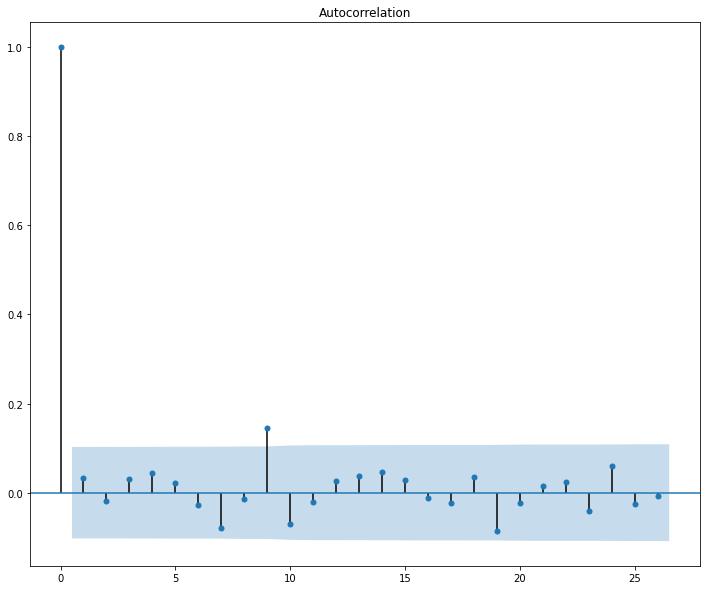

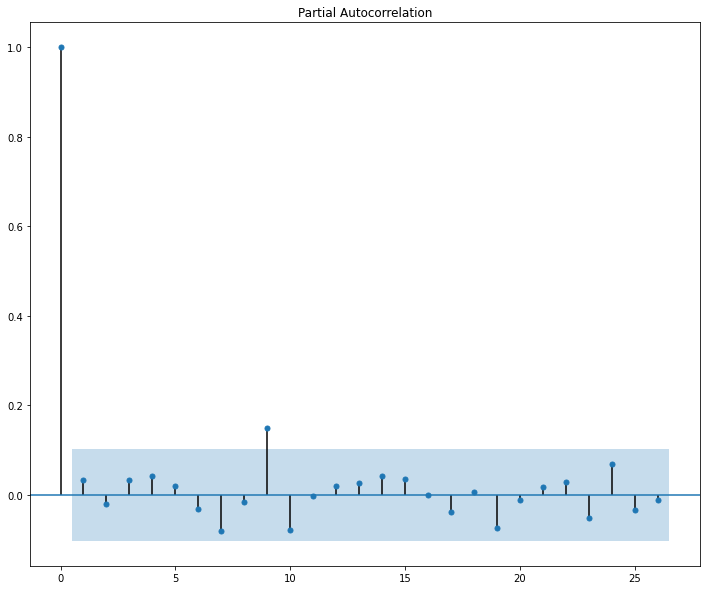

In [83]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p-value 값이 아주 작아졌기 때문에 1차분만 해도 될 것 같음.
- 따라서 ARIMA의 모수로 d=1이 적당할 것 같음.
- 또한 ACF 그래프에서 1시차 이후에 급격하게 0으로 수렴하는 모습을 보이기때문에 q=1, PACF 그래프에서 1시차 이후에 급격하게 0으로 수렴하는 모습을 보이기 때문에 p=1이 적당할 것 같다.

## step5. 학습, 테스트 데이터 생성

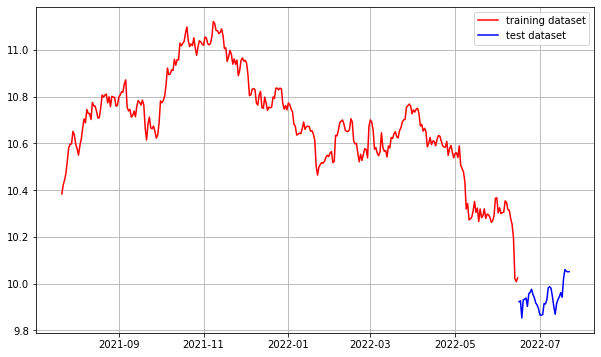

In [84]:
# 데이터가 시계열 데이터 이므로 학습을 시간으로 앞선 데이터로 해준다.
# train, test 비율은 9:1로 설정
train_data = ts1_log[:int(len(ts1_log)*0.9)]
test_data = ts1_log[int(len(ts1_log)*0.9):]

#버전 때문인진 몰라도 계속 오류 메세지가 나와서 추가해줌
train_data.index = pd.DatetimeIndex(train_data.index.values,
                               freq=train_data.index.inferred_freq)
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## step6. 모델 훈련, 테스트

In [85]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model_1 = ARIMA(train_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 | 모수를 구할 때 p와 q를 둘 다 구했지만 p,q둘 중 하나는 0이 되어아함
fit_model_1 = model_1.fit() 

print(fit_model_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 627.041
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sat, 23 Jul 2022   AIC                          -1248.082
Time:                        12:34:57   BIC                          -1236.703
Sample:                    07-23-2021   HQIC                         -1243.542
                         - 06-15-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.002     -0.524      0.600      -0.005       0.003
ar.L1.D.Close     0.0460      0.055      0.833      0.405      -0.062       0.154
                                    Root

In [86]:
model_2 = ARIMA(train_data, order=(0,1,1))
fit_model_2 = model_2.fit()

print(fit_model_2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 627.079
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sat, 23 Jul 2022   AIC                          -1248.158
Time:                        12:34:57   BIC                          -1236.778
Sample:                    07-23-2021   HQIC                         -1243.618
                         - 06-15-2022                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.002     -0.523      0.601      -0.005       0.003
ma.L1.D.Close     0.0511      0.058      0.877      0.381      -0.063       0.165
                                    Root

- ARIMA(10,1,0) , ARIMA(1,1,0) 두개의 모델을 비교 했을 때 AIC가 아주 조금이나마 ARIMA(10,1,0)이 낮아졌으므로 예측에 fit_model_2를 채택

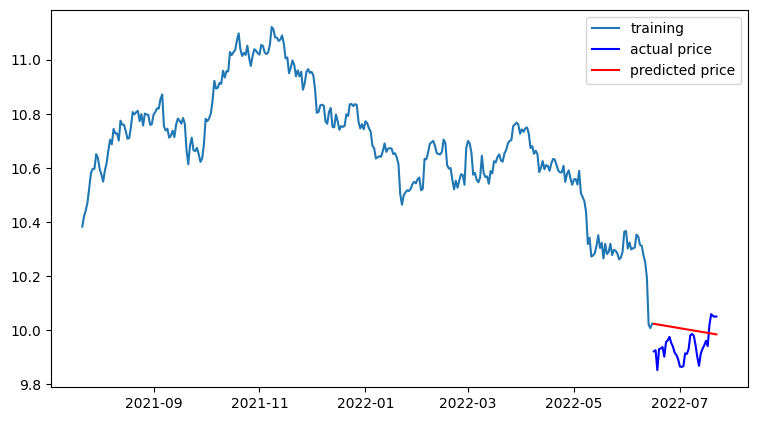

In [87]:
model = ARIMA(train_data, order=(1, 1, 0))  # p값을 1로 학습
fit_model = model.fit() 
fc= fit_model.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc=np.array(fc[0])
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 다양한 계산 방법으로 오차 계산

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3358227.5039211656
MAE:  1672.761439531355
RMSE:  1832.5467262586146
MAPE: 8.19%


# 애플

## step1. 시계열 데이터 준비

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statsmodels
import os

import warnings
warnings.filterwarnings(action='ignore')

In [90]:
apple_data = pd.read_csv('/content/drive/MyDrive/캐글_필사/data_주식/AAPL.csv',index_col = 'Date', parse_dates=True)
apple_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-22,145.940002,148.199997,145.809998,146.800003,145.966064,77338200
2021-07-23,147.550003,148.720001,146.919998,148.559998,147.716064,71447400
2021-07-26,148.270004,149.830002,147.699997,148.990005,148.143631,72434100
2021-07-27,149.119995,149.210007,145.550003,146.770004,145.936249,104818600
2021-07-28,144.809998,146.970001,142.539993,144.979996,144.156387,118931200


- 종가(Close)을 기준으로 진행을 할 것

In [91]:
ts_apple = apple_data['Close']
ts_apple.head()

Date
2021-07-22    146.800003
2021-07-23    148.559998
2021-07-26    148.990005
2021-07-27    146.770004
2021-07-28    144.979996
Name: Close, dtype: float64

## step2. 각종 전처리

- 결측치 처리
- 로그 변환

In [92]:
ts_apple.isnull().sum()

0

결측치가 하나도 없는 것을 볼 수 있음.

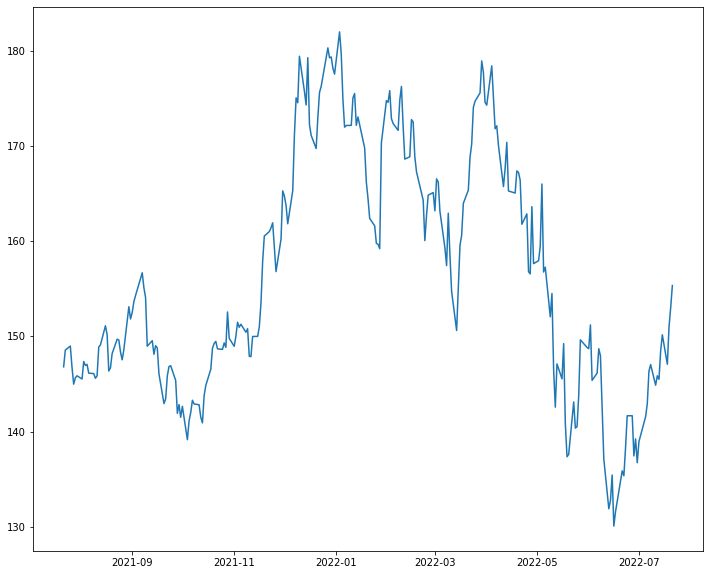

In [93]:
plt.plot(ts_apple)

## step3. 시계열 안정성 분석

  - 정성적 그래프 분석
  - 정량적 Augumented Dickey-Fuller test
  - 시계열 분해(Time Series Decomposition)
  - Residual 안정성 확인

In [94]:
# 정성적 그래프 분석 함수 정의
# 이동평균, 이동표준편차 등을 시각화 해줌

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

#정량적 Augmented_Dicky_Fuller_Test 함수 정의
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

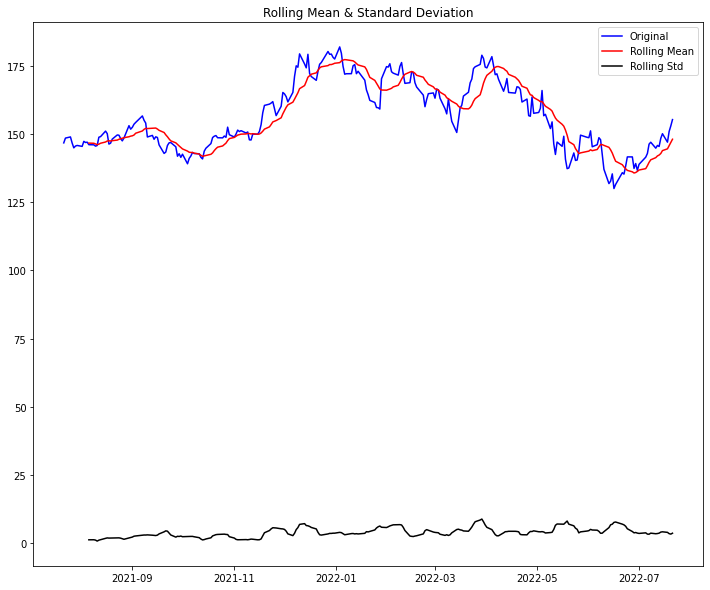

In [95]:
plot_rolling_statistics(ts_apple)

In [96]:
augmented_dickey_fuller_test(ts_apple)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941436
p-value                          0.312826
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


ts_apple에 대해 augmented_dickey_fuller_test를 해봤을때 p-value가 0.312826으로 0.05보다 크다. 따라서 ts_apple이 안정적인 시계열 데이터가 아니라는 귀무가설을 기각할 수 없다.

In [97]:
ts_apple_log = np.log(ts_apple)

In [98]:
augmented_dickey_fuller_test(ts_apple_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.947899
p-value                          0.309874
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


로그 변환을 해도 p-value에 큰 차이가 없다.

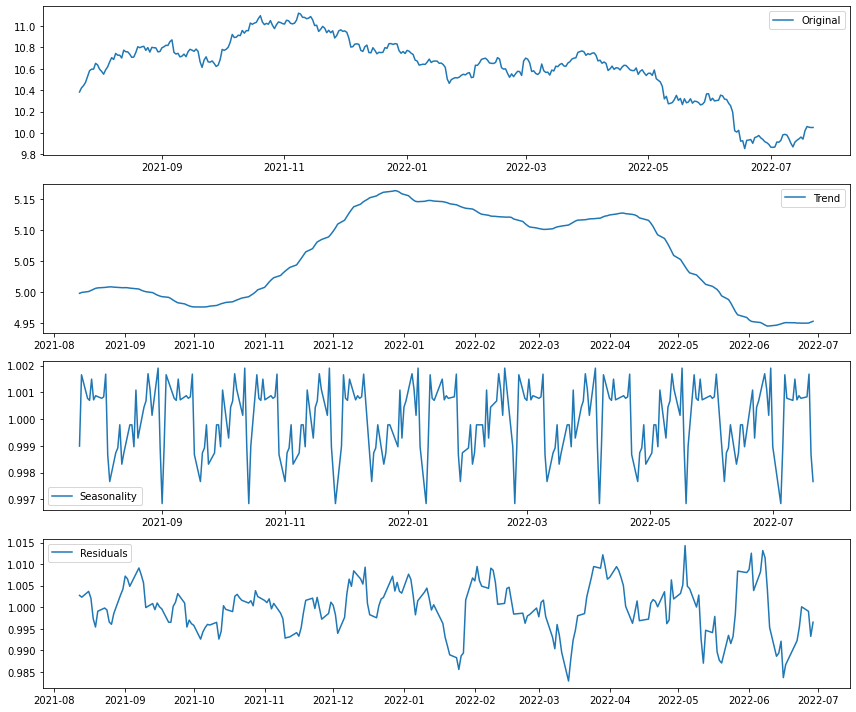

In [99]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_apple_log, model='multiplicative', freq = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [100]:
residual.isnull().sum()

30

- residual에 결측치가 확인 되었으므로 결측치를 제거해줌
- 결측치 제거 후에 residual에 대한 안정성 측정을 해준다.

In [101]:
residual = residual.dropna()

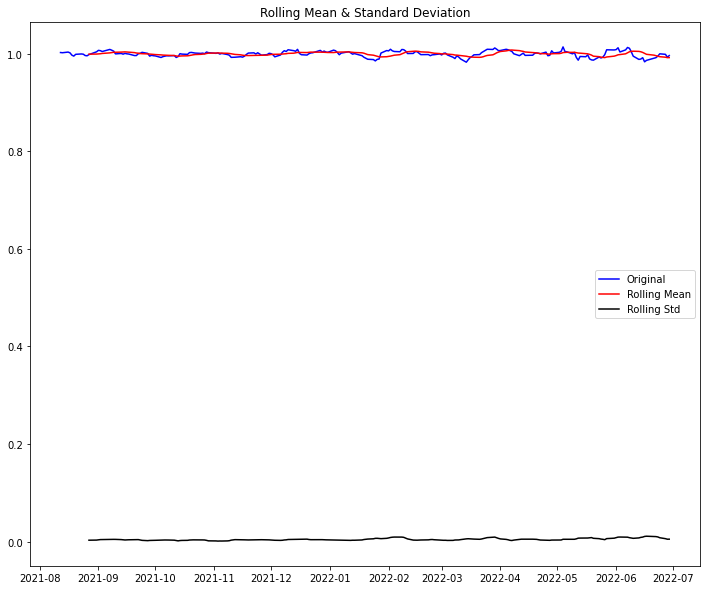

In [102]:
plt.rcParams["figure.figsize"] = (12,10)
plot_rolling_statistics(residual)

In [103]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.919813
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


residual에 대한 p-value가 0.05보다 충분히 작기때문에 안정적이라고 볼 수 있다.

## step4. 적정 ARIMA 모수 찾기

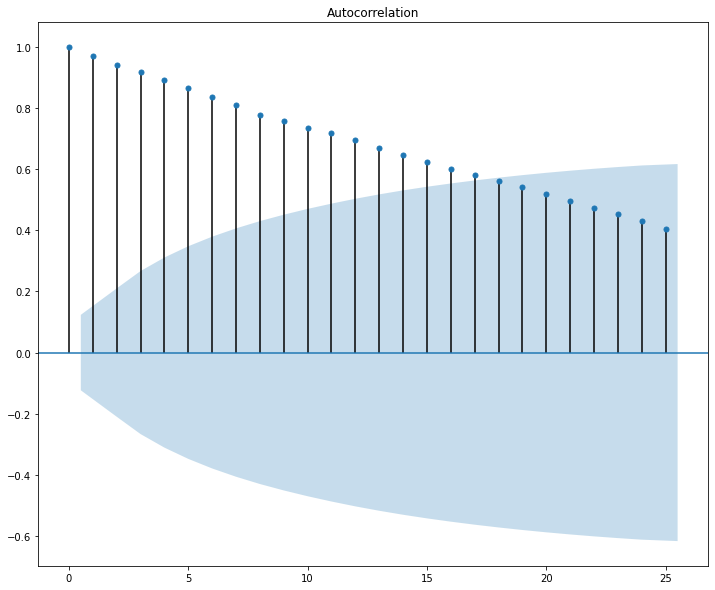

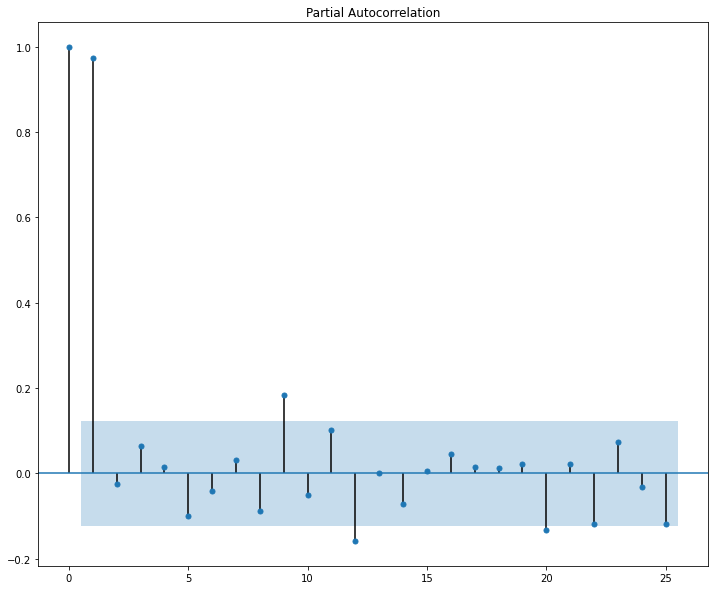

In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_apple_log)
plot_pacf(ts_apple_log)
plt.show()

- pacf그래프에서 p=1이후에 급격하게 0에 수렴하는 것을 볼 수 있으므로 p=1이 적당해 보인다. 하지만 acf그래프는 천천히 0에 수렴하는 것으로 보아 안정적 시계열이 아니라고 볼 수 있다. 따라서 차분을 하고 다시 확인해봐야한다.

In [107]:
diff_1 = ts_apple_log.diff(periods=1).iloc[1:]

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.550614e+01
p-value                        2.381027e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


- p-value가 아주 작은 값이므로 충분히 안정적이라고 볼 수 있다.
- 따라서 arima모수의 d=1이 적당할 것 같다.

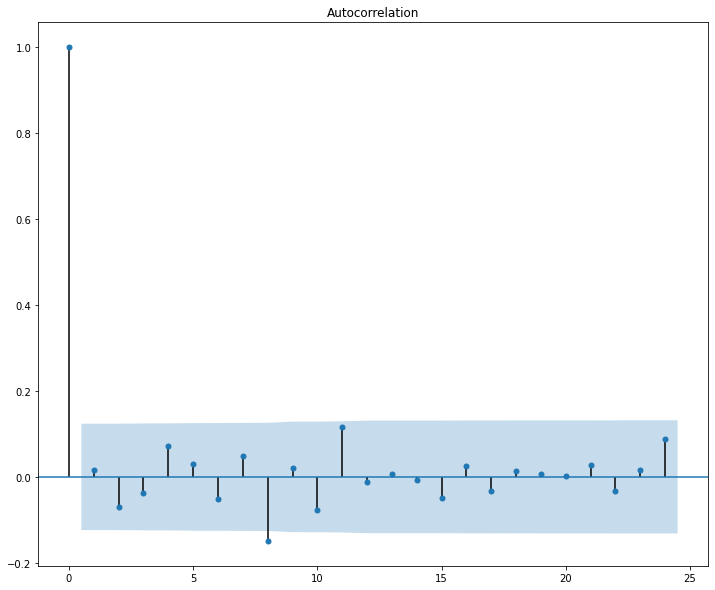

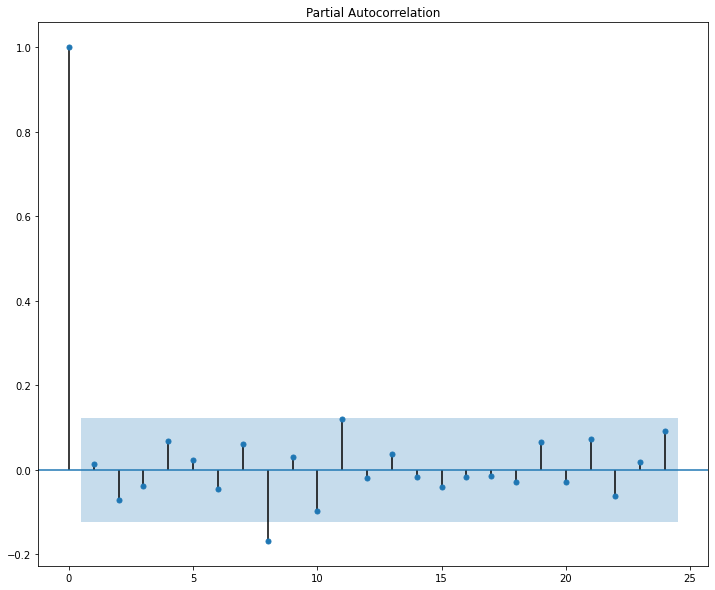

In [108]:
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

- p와 q가 1이후로 급격하게 0으로 수렴하는것을 볼 수 있다. 따라서 arima모수로 p=1, q=1, d=1을 채택할 수 있다.

## step5. 학습, 테스트 데이터 생성

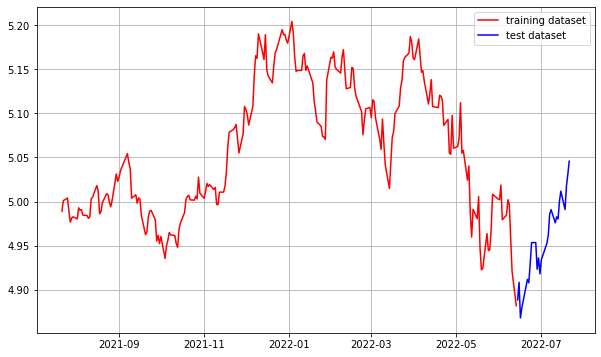

In [109]:
train_data = ts_apple_log[:int(len(ts_apple_log)*0.9)]
test_data = ts_apple_log[int(len(ts_apple_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## step6. 모델 훈련, 테스트

- p=1, d=1을 모수로 넣은 model_1

In [111]:
from statsmodels.tsa.arima_model import ARIMA

model_1 = ARIMA(train_data, order=(1,1,0))
fitted_model_1 = model_1.fit()

print(fitted_model_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 574.609
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 23 Jul 2022   AIC                          -1143.219
Time:                        12:56:15   BIC                          -1132.970
Sample:                             1   HQIC                         -1139.082
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.371      0.711      -0.003       0.002
ar.L1.D.Close     0.0301      0.067      0.448      0.655      -0.102       0.162
                                    Root

- d=1, q=1을 모수로 갖는 model_2

In [112]:
model_2 = ARIMA(train_data, order=(0,1,1))
fitted_model_2 = model_2.fit()

print(fitted_model_2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 574.622
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 23 Jul 2022   AIC                          -1143.244
Time:                        12:57:11   BIC                          -1132.996
Sample:                             1   HQIC                         -1139.108
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0005      0.001     -0.370      0.712      -0.003       0.002
ma.L1.D.Close     0.0338      0.071      0.478      0.633      -0.105       0.172
                                    Root

- 두 모델의 AIC값을 봤을때 model_2가 아주 근소하게 값이 작으므로 model_2를 예측 모델로 선정

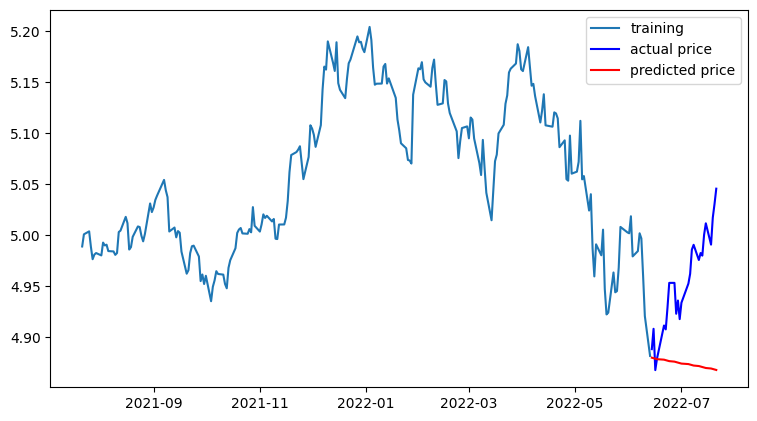

In [113]:
model_2 = ARIMA(train_data, order=(0, 1, 1))  
fit_model = model_2.fit() 
fc= fit_model.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc=np.array(fc[0])
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [114]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  175.71404154208741
MAE:  11.330680956835296
RMSE:  13.255717315260137
MAPE: 7.77%
